In [1]:
# !pip install albumentations tensorflow torch torchvision matplotlib Pillow opencv-python

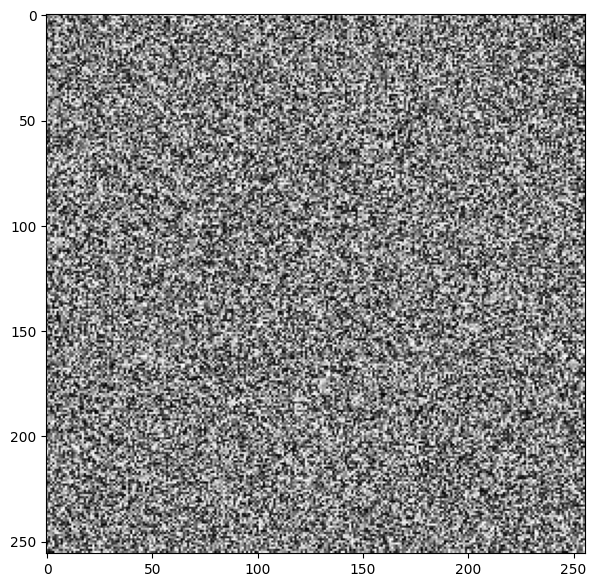

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# generate random numpy array with values from 0 to 255
# and a size of 256x256
random_image = np.random.randint(0, 256, (256, 256))
# initialize plot
plt.figure(figsize=(7, 7))
# show grayscale image, nb: cmap, vmin and vmax
plt.imshow(random_image, cmap='gray', vmin=0, vmax=255)
plt.show()

# classification

In [3]:
import os 
import pandas as pd

In [4]:
folder = 'datasets/Alzheimer_dataset/' 
class_map = {
    'MildDemented': 1,
    'ModerateDemented':1,
    'NonDemented':0, 
    'VeryMildDemented':1
      }
for type_ in os.listdir(folder):
    results = []
    # train/test
    classes = os.listdir(folder+type_) 
    # classes names
    for c in classes:
        for im in os.listdir(folder + type_ + "/" + c):
            results.append([folder + type_ + "/" + c + "/" + im, c, class_map[c]])

    df = pd.DataFrame(results, columns=['im_path', "class", 'target'])
    df.to_csv(f"datasets/{type_}_xray.csv", index=False)

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from tqdm import tqdm

In [6]:
def create_dataset(training_df):
    # create empty list to store image vectors
    images = []
    # create empty list to store targets
    targets = []
    # loop over the dataframe
    for index, row in tqdm(
                            training_df.iterrows(),
                            total=len(training_df),
                            desc="processing images"
                            ):
        # get image id
        image_path = row["im_path"]
        # open image using PIL
        image = Image.open(image_path)
        # resize image to 256x256. we use bilinear resampling
        image = image.resize((256, 256), resample=Image.BILINEAR)
        # convert image to array
        image = np.array(image)
        # ravel
        image = image.ravel()
        # append images and targets lists
        images.append(image)
        targets.append(int(row["target"]))
    
    # convert list of list of images to numpy array
    images = np.array(images)
    return images, targets

In [7]:
df = pd.read_csv(r'C:\Users\Baban\Desktop\ML\datasets\train_xray.csv') 
df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df.target.values
kf = model_selection.StratifiedKFold(n_splits=5)
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f


In [8]:
# for fold_ in range(1):
#     # temporary dataframes for train and test
#     train_df = df[df.kfold != fold_].reset_index(drop=True)
#     test_df = df[df.kfold == fold_].reset_index(drop=True)

#     # create train dataset
#     # you can move this outside to save some computation time
#     xtrain, ytrain = create_dataset(train_df)
#     # create test dataset
#     # you can move this outside to save some computation time
#     xtest, ytest = create_dataset(test_df)
#     # fit random forest without any modification of params
#     clf = ensemble.RandomForestClassifier(n_jobs=-1)
#     clf.fit(xtrain, ytrain)
#     # predict probability of class 1
#     preds = clf.predict_proba(xtest)[:,1]
#     # print results
#     print(f"FOLD: {fold_}")
#     print(f"AUC = {metrics.roc_auc_score(ytest, preds)}")
#     print("")

# AlexNet 

In [9]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 

In [45]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 1))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [46]:
import torch
import numpy as np
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [47]:
class ClassificationDataset:
    def __init__(self, im_paths, targets, resize=None, augmentations=None):
        self.im_paths = im_paths 
        self.targets = targets 
        self.resize = resize 
        self.augmentations = augmentations 

    def __len__(self):
        return len(self.im_paths) 

    def __getitem__(self, item):
        image = Image.open(self.im_paths[item])
        targets = self.targets[item]

        if self.resize is not None:
            image = image.resize(
                                (self.resize[1], self.resize[0]),
                                resample=Image.BILINEAR
                                )
            
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]

        return {
                "image": torch.tensor(image, dtype=torch.float),
                "targets": torch.tensor(targets, dtype=torch.long),
                }

In [48]:
import torch 
import torch.nn as nn 
from tqdm import tqdm 

In [49]:
def evaluate(data_loader, model, device):
    model.eval() 
    final_targets = [] 
    final_outputs = [] 

    with torch.no_grad():
        for data in tqdm(data_loader, desc='eval data'):
            inputs = data['image'].to(device, dtype=torch.float)
            targets = data['targets'].to(device, dtype=torch.float)

            output = model(inputs)
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(output)

    return final_outputs, final_targets


In [50]:
model = AlexNet()

In [51]:
model

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

# training begins

In [52]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [53]:
import os
import pandas as pd
import numpy as np
import albumentations
import torch
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [54]:
df = pd.read_csv('datasets/train_xray.csv')
images = df['im_path'].to_list() 
targets = df.target.values
train_images, valid_images, train_targets, valid_targets = train_test_split(
                                                                            images, targets, stratify=targets, random_state=42
                                                                            )

In [55]:
train_dataset = ClassificationDataset(im_paths=train_images, targets=train_targets, resize=(227, 227))
valid_dataset = ClassificationDataset(im_paths=valid_images, targets=valid_targets, resize=(227, 227))

In [56]:
train_loader = torch.utils.data.DataLoader(
                                            train_dataset, batch_size=2, shuffle=True
                                            )

valid_loader = torch.utils.data.DataLoader(
valid_dataset, batch_size=2, shuffle=False
 )

In [57]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [58]:
import torchvision

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [60]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)

In [61]:
epochs = 2 
device = 'cpu' 
criterion = nn.BCEWithLogitsLoss()

In [62]:
for epoch in tqdm(range(epochs)):
    for data in tqdm(train_loader, desc='train_loader'):
        inputs = data['image'].to(device, dtype=torch.float)
        targets = data['targets'].to(device, dtype=torch.float)
        optimizer.zero_grad() 
        outputs = model(inputs)
        loss = (outputs, targets.view(-1, 1))
        loss.backward() 
        optimizer.step()

    if epoch ==0:
        print("training done --")
   
    predictions, valid_targets = evaluate(
                                            valid_loader, model, device=device
                                            )
    roc_auc = metrics.roc_auc_score(valid_targets, predictions)
    print(
        f"Epoch={epoch}, Valid ROC AUC={roc_auc}"
        )

  0%|          | 0/2 [00:00<?, ?it/s]


ValueError: expected 4D input (got 3D input)